In [1]:
# Import necessary PySpark modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import column
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
import matplotlib.pyplot as plt
import pandas as pd

# Create a Spark session
spark = SparkSession.builder.master("local").appName("kNearestNeightbor").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/09 12:14:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df_raw = spark.read.csv("../data/processed/sample_df.csv", header=True, inferSchema=True)

In [3]:
# Get the names of all the columns in the DataFrame
df_raw = df_raw.select("Severity", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)")
df_casted = df_raw.select([column(c).cast(FloatType()) for c in df_raw.columns])
column_names = df_raw.columns

# Print the column names
for column_name in column_names:
    print(column_name)

Severity
Temperature(F)
Humidity(%)
Pressure(in)
Visibility(mi)
Wind_Speed(mph)
Precipitation(in)


Modify these Features:

In [14]:
feature_1 = "Visibility(Mi)"
feature_2 = "Temperature(F)"

In [15]:
def fit_kmeans(df_input,num_cluster_centers=3):
    '''
    Requires
    df_input: spark dataframe with column name "features" having vector of real-valued inputs
    num_cluster_centers: integer that tells the algorithm the value of k
    Returns
    cluster_data: spark dataframe with predictions
    silhouette_score: float with silhouette score
    wcss: float within cluster sum of squares
    '''
    # Create a K-Means instance
    kmeans = KMeans().setK(num_cluster_centers).setSeed(1)
    
    # Fit the K-Means model to the data
    model = kmeans.fit(df_input)
        
    # Get the cluster assignments for each data point
    clustered_data = model.transform(df_input)

    # Evaluate the clustering using the ClusteringEvaluator
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clustered_data)

    # Print the silhouette score
    print(f"Silhouette Score: {silhouette_score}")
    # Print the WCSS (Within-Cluster Sum of Squares)
    wcss = model.summary.trainingCost
    print(f"Within cluster sum of squares: {wcss}")
    
    # Return the clustered data
    return clustered_data, silhouette_score, wcss

In [16]:
def visualize_clusters_2D(clustered_data, feature_1, feature_2,  num_cluster_centers=3):
    '''
    Requires:
    clustered_data: dataframe returned from Kmeans fit
    num_cluster_centers: integer number of clusters
    feature_1: string with identifiers for first column name
    feature_2: string with identifiers for second column name
    '''
    
    # Convert the DataFrame to a Pandas DataFrame for visualization
    pandas_df = clustered_data.select(feature_1, feature_2, "prediction").toPandas()
    
    # Extract the cluster assignments
    cluster_assignments = pandas_df["prediction"]
    
    # Extract the feature values
    feature1 = pandas_df[feature_1]
    feature2 = pandas_df[feature_2]
    
    # Create a scatter plot for each cluster
    for cluster_id in range(num_cluster_centers):
        cluster_data = pandas_df[pandas_df["prediction"] == cluster_id]
        plt.scatter(cluster_data[feature_1], cluster_data[feature_2], label=f'Cluster {cluster_id}')
    
    # Set labels and title
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title("K-Means Clustering")
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

In [17]:
assembler = VectorAssembler(inputCols = column_names, outputCol = 'features', handleInvalid="skip")
df_vector = assembler.transform(df_raw)

Silhouette Score: 0.4713526449994504
Within cluster sum of squares: 186248.60224815956


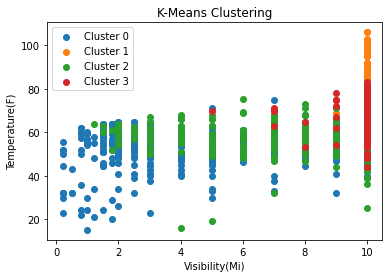

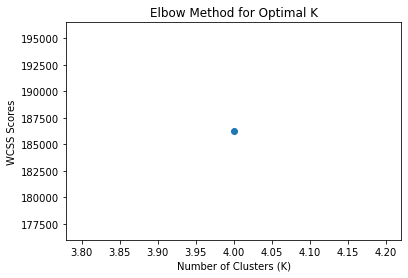

In [18]:
k_values = [4]  # There are 4 different levels of severity, Categorizing based on that

silhouette_scores = []
wcss_scores = []

for k in k_values:
    clustered_data, silhouetteScore, wcss = fit_kmeans(df_vector,num_cluster_centers=k)
    silhouette_scores.append(silhouetteScore)
    wcss_scores.append(wcss)

    
    visualize_clusters_2D(clustered_data, feature_1, feature_2, k)
    
# Plot the Elbow Method curve
plt.plot(k_values, wcss_scores, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

In [19]:
spark.stop()